In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt
Pi = math.pi

In [8]:
# Poisson solver for parallel-plate capacitor

# Simulation parameters
Lx = 2
Ly = 1
# Grid spacing
h = 0.1

x = np.arange(-1/2*Lx, 1/2*Lx, h)
y = np.arange(-1/2*Ly, 1/2*Ly, h)
# build axes matrix
X,Y = np.meshgrid(x,-y)

# number of voltage samples
Nx = x.size
Ny = y.size

# Parallel plate parameters
Vtop = 1
Vbot = -1
L = 1
W = 0.2
x1 = -L/2
x2 = L/2
y1 = -W/2
y2 = W/2

# SOR modules
Ni = 10000   #total iterations
t = math.cos(Pi/Nx) + math.cos(Pi/Ny)
omega = ( 8-math.sqrt(64-16*pow(t,2)) )/pow(t,2)



In [9]:
#####################################

# Initialize simulation parameters matrices

#####################################

#  Initialize matrices.
V   = np.zeros((Ny,Nx));         #  Potential function (V).
BC  = np.zeros((Ny,Nx));         #  Boundary conditions (boolean).
RHO = np.zeros((Ny,Nx));         #  Charge distrubution (C/m^2).

# simulation boundary
BC[0,:]  = 1
BC[-1,:] = 1
BC[:,0]  = 1
BC[:,-1] = 1

# Pick up points on plate
bP=(X <= x2)*(X >= x1)*(Y <= y1+h/2)*(Y >= y1-h/2)  #Bottom Plate
V[bP] = Vbot
BC[bP] = 1
tP=(X <= x2)*(X >= x1)*(Y <= y2+h/2)*(Y >= y2-h/2)  #Top Plate
V[tP] = Vtop
BC[tP] = 1

In [10]:
from multiprocessing import process,pool
import os

n_core=4


# SOR solver
EPS_0 = 8.854e-12
maxError = 1e-6
# [ta,tb] = V.shape
# b-matrix for SOR 
b = RHO*pow(h,2)/EPS_0 #surface charge density

for i in range(Ni):
    maxR = 0
    for jj in range(Ny):
        for ii in range(Nx):
            # Neumann boundary
            if (jj == 0):
                V[jj,ii] = V[jj+1,ii]
                continue
            if (jj == Ny-1):
                V[jj,ii] = V[jj-1,ii]
                continue
            if (ii == 0):
                V[jj,ii] = V[jj,ii+1]
                continue
            if (ii == Nx-1):
                V[jj,ii] = V[jj,ii-1]
                continue
            if (BC[jj,ii] == 1): # Dirichlet boundary
                continue
            # none of the boundary conditions being trigged, then calculate the residual using 5-point star
            R = 0.25*( V[jj+1,ii]+V[jj-1,ii]+V[jj,ii+1]+V[jj,ii-1]+b[jj,ii] ) - V[jj,ii]

            V[jj,ii] = V[jj,ii] + omega*R # update
            maxR = max(maxR,abs(R))
    if (maxR < maxError):
        break
    
    print("Iteration:"+ str(i)+"  MaxError:"+str(maxR)) # log

Iteration:0  MaxError:0.41761502846664506
Iteration:1  MaxError:0.2798664849885973
Iteration:2  MaxError:0.18727780416424258
Iteration:3  MaxError:0.09702201649613111
Iteration:4  MaxError:0.06491006722112874
Iteration:5  MaxError:0.05211167912783339
Iteration:6  MaxError:0.03660716766379375
Iteration:7  MaxError:0.023511434287388437
Iteration:8  MaxError:0.02586263736804551
Iteration:9  MaxError:0.009286764635798347
Iteration:10  MaxError:0.007744648777099608
Iteration:11  MaxError:0.005473585083418806
Iteration:12  MaxError:0.003174862200799794
Iteration:13  MaxError:0.0020089321778746227
Iteration:14  MaxError:0.001618772385934858
Iteration:15  MaxError:0.0010773166958973346
Iteration:16  MaxError:0.000634202366011638
Iteration:17  MaxError:0.00043061210974287834
Iteration:18  MaxError:0.00027267338828029786
Iteration:19  MaxError:0.0001762334635056484
Iteration:20  MaxError:0.00013674686121162294
Iteration:21  MaxError:9.153241714021654e-05
Iteration:22  MaxError:7.146592711926303e

<ipython-input-11-e5f3a60710bd>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X,Y,V)


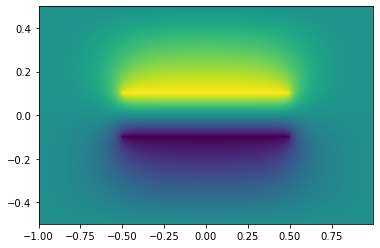

In [11]:
# Render potential V's image
plt.pcolor(X,Y,V)
plt.show()

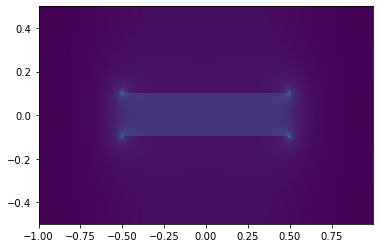

In [12]:
# Numerical gradient
dh = 1 # Default step for numerical gradient

tEx = np.zeros((Ny, Nx-1))
tEy = np.zeros((Ny-1, Nx))
Ex = np.zeros((Ny-1, Nx-1))
Ey = np.zeros((Ny-1, Nx-1))

for i in range(Ny):
    tEx[i,:] = (1/h)*( V[i,1:]-V[i,:-1] )
for j in range(Nx):
    tEy[:,j] = (1/h)*( V[1:,j]-V[:-1,j] )
    if (j == Nx-1):
        continue
    Ex[:,j] = 0.5*( tEx[:-1,j]+tEx[1:,j] ) # Average along y-axis
for i in range(Ny-1):
    Ey[i,:] = 0.5*( tEy[i,:-1]+tEy[i,1:] ) #Average along x-axis

Emag = np.sqrt(pow(Ex,2)+pow(Ey,2))

plt.pcolor(X,Y,Emag)
plt.show()